In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
import sys
import datetime
import logging

print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')
print('Python version ' + sys.version)
print('Numpy version ' + np.version.version)
print('Pandas version ' + pd.__version__)
print('MatplotLib version ' + matplotlib.__version__)
print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')
logging.info('Program start.')

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Python version 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
Numpy version 1.16.2
Pandas version 0.24.2
MatplotLib version 3.0.3
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


In [128]:
# Hardcoded filepath for testing and dev purposes
file = 'latest.log'

# Initialize the data array
data = pd.DataFrame(dtype=float)

temp = []
with open(file) as f:
    for line in f.readlines():
        # If it's a line with eco stat data (they are all flagged)
        if 'ECOSTATS' in line:
            # Cut off the preceding bits we dont care about
            cache = line.split(sep='ECOSTATS: ,')[1]
            
            
            temp.append(cache.split(sep=','))
            
data = data.append(temp)
data.columns=['Time', 'Team',
              'Food_Prod', 'Lumber_Prod', 'Stone_Prod', 'Iron_Prod', 'Gold_Prod', 'Diamond_Prod', 'Emerald_Prod',
              'Food', 'Lumber', 'Stone', 'Iron', 'Gold', 'Diamonds', 'Emeralds'
             ]


data.Time = pd.to_datetime(data.Time)
data.Team = data.Team.astype(str)
data[['Food_Prod', 'Lumber_Prod', 'Stone_Prod', 'Iron_Prod']] = data[['Food_Prod', 'Lumber_Prod', 'Stone_Prod', 'Iron_Prod']].astype(int)
data[['Gold_Prod', 'Diamond_Prod', 'Emerald_Prod']] = data[['Gold_Prod', 'Diamond_Prod', 'Emerald_Prod']].astype(int)
data[['Food', 'Lumber', 'Stone', 'Iron']] = data[['Food', 'Lumber', 'Stone', 'Iron']].astype(int)
data[['Gold', 'Diamonds', 'Emeralds']] = data[['Gold', 'Diamonds', 'Emeralds']].astype(int)
print(data.dtypes)

Time            datetime64[ns]
Team                    object
Food_Prod                int32
Lumber_Prod              int32
Stone_Prod               int32
Iron_Prod                int32
Gold_Prod                int32
Diamond_Prod             int32
Emerald_Prod             int32
Food                     int32
Lumber                   int32
Stone                    int32
Iron                     int32
Gold                     int32
Diamonds                 int32
Emeralds                 int32
dtype: object


In [129]:
def teamResourcePlot(df, team='red', p=True):
    '''
    Creates a resource plot for a team. Valid team names are: red, blue, green, yellow.
    If p is True include production rates for all resources on the plot.
    
    Returns a matplotlib figure and axes and plots the figure.
    '''
    # Copy the data for this team only
    df = data.loc[data.Team == team].copy()
    
    # Drop the uninteresting bits.
    # For now, start plotting after the townhall is placed (when production initializes)
    # The townhall generates some food, so as long as it is positive, the team is still in play.
    df = df.loc[df.Food >= 0].copy()
    
    # Set time to be index for automatic plots crossed with time
    df.set_index(df.Time, inplace=True)
    
    if p:
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(19,14) )
        ax1 = df.plot(ax=axes[0], y=['Food', 'Lumber', 'Stone', 'Iron', 'Gold'], color=['orange', 'g', 'k', 'grey', 'gold'])
        ax2 = df.plot(ax=axes[1], y=['Food_Prod', 'Lumber_Prod', 'Stone_Prod', 'Iron_Prod', 'Gold_Prod'], color=['orange', 'g', 'k', 'grey', 'gold'], style=':')
        
        ax1.set_title('{} Team Resources\n'.format(team.title()), fontsize=24)
        ax1.set_xlabel(None)
        
        ax1.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.003))
        ax2.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.003))
        
        ax1.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.0003))
        ax2.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.0003))
        
        ax2.set_title('Production Rates')

    else:
        ax1 = df.plot(y=['Food', 'Lumber', 'Stone', 'Iron', 'Gold'], figsize=(19,7), title='{} Team Resources'.format(team.title()))
        fig = ax1.get_figure()
    
    return fig, ax1

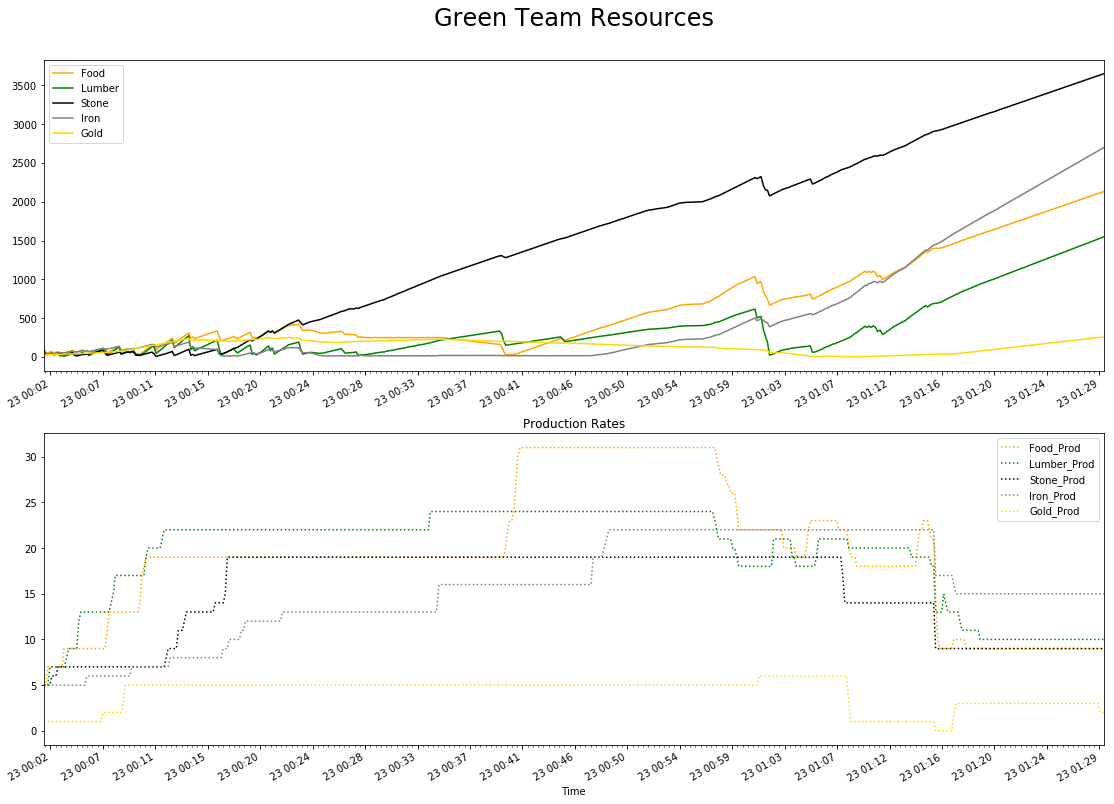

In [132]:
team = 'green'
fig, ax = teamResourcePlot(data, team=team, p=True)
fig.savefig('{}.png'.format(team))

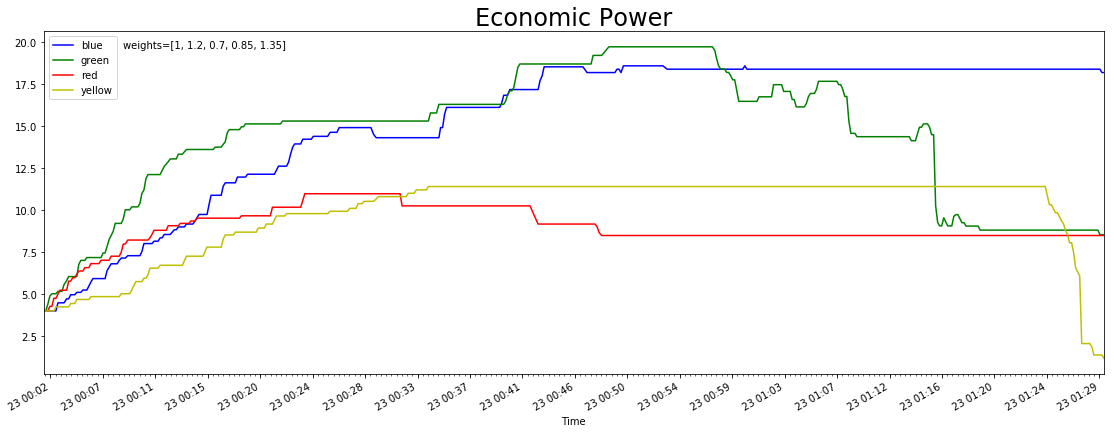

In [130]:
# production weights
w = [1, 1.2, 0.7, 0.85, 1.35]
# team = data.loc[data.Team == 'red'].copy()
data['Econ'] = (data.Food_Prod*w[0] + data.Lumber_Prod*w[1] + data.Stone_Prod*w[2] + data.Iron_Prod*w[3] + data.Gold_Prod*w[4])/len(w)
data.set_index(data.Time, inplace=True)
# Trim the data before the townhall is placed.
data = data.loc[data.Food_Prod >= 5].copy()

# initiate the plot
fig, ax = plt.subplots(figsize=(19,7))

# group the data by team, and add each one to the axes with the appropriate color
for name, group in data.groupby(data.Team):
    group.Econ.plot(ax=ax, color=name[:1],label=name)
    

ax.legend()
ax.set_title('Economic Power', fontsize=24)
ax.text(0.075, 0.95, s='weights={}'.format(w), transform=ax.transAxes)
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.003))
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.0003))
plt.show()
fig.savefig('Econ.png')